In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram as tg
import geopandas as gpd
from shapely.geometry import Polygon
import muon as mu
import anndata as ad

%load_ext autoreload
%autoreload 2
%matplotlib inline

/nfs/home/students/l.reich/mamba/envs/neu/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/nfs/home/students/l.reich/mamba/envs/neu/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## Spatial data

In [2]:
# Load merged file
segmented_cells = pd.read_csv("data/spatial_data/MERFISH_MOp/processed_data/all_segmented_cells.csv")

In [3]:
segmented_cells = segmented_cells.reset_index().rename(columns={"index": "cell_id"})

In [4]:
slice_counts = segmented_cells["slice_id"].value_counts()

slice = "mouse1_slice201"

segmented_cells_selected = segmented_cells[segmented_cells["slice_id"] == slice]

In [5]:
adata_st = sc.read_h5ad("data/spatial_data/MERFISH_MOp/processed_data/counts.h5ad")

cell_labels = pd.read_csv("data/spatial_data/MERFISH_MOp/processed_data/cell_labels.csv", index_col=0)  # Use sample_id as index

# Ensure index matches adata_st.var
cell_labels = cell_labels.loc[adata_st.obs.index]  

# Add to AnnData
adata_st.obs = cell_labels

In [6]:
adata_subset = adata_st[adata_st.obs["slice_id"] == slice].copy()

In [7]:
def get_centroid(row):
    all_x = []
    all_y = []
    # Collect boundary coordinates, handle NaN gracefully
    for i in range(7):  # Adjust based on the number of slices
        x_col = f"boundaryX_z{i}"
        y_col = f"boundaryY_z{i}"

        if pd.notna(row[x_col]) and pd.notna(row[y_col]):
            # Ensure we are extracting valid data
            x_values = list(map(float, str(row[x_col]).split(',')))

            y_values = list(map(float, str(row[y_col]).split(',')))

            if len(x_values) == len(y_values):  # Ensure matching x/y pairs
                all_x.extend(x_values)
                all_y.extend(y_values)

    # Proceed only if enough coordinates are available
    if len(all_x) > 2 and len(all_y) > 2:  # Ensure enough points for a polygon
        polygon = Polygon(zip(all_x, all_y))
        return polygon.centroid.x, polygon.centroid.y
        #if polygon.is_valid and not polygon.is_empty:
         #   return polygon.centroid.x, polygon.centroid.y
    
    # If there are no valid polygon points, use a fallback (average of available points)
    if len(all_x) > 0 and len(all_y) > 0:
        return np.mean(all_x), np.mean(all_y)
    return np.nan, np.nan  # Return NaN if no valid coordinates

In [8]:
segmented_cells_selected["centroid_x"], segmented_cells_selected["centroid_y"] = zip(*segmented_cells_selected.apply(get_centroid, axis=1))

In [9]:
segmented_cells_selected["cell_id"] = segmented_cells_selected["Unnamed: 0"].astype(str)
adata_subset.obs["cell_id"] = adata_subset.obs.index.astype(str)

adata_subset.obs = adata_subset.obs.merge(segmented_cells_selected[["cell_id", "centroid_x", "centroid_y"]], 
                                  on="cell_id", how="left")

In [10]:
adata_subset.obsm["spatial"] = np.array(adata_subset.obs[["centroid_x", "centroid_y"]])

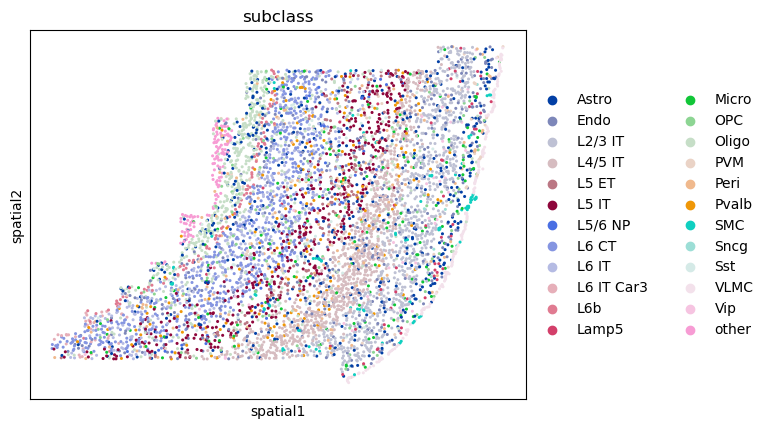

In [11]:
sc.pl.embedding(adata_subset, basis="spatial", color="subclass")

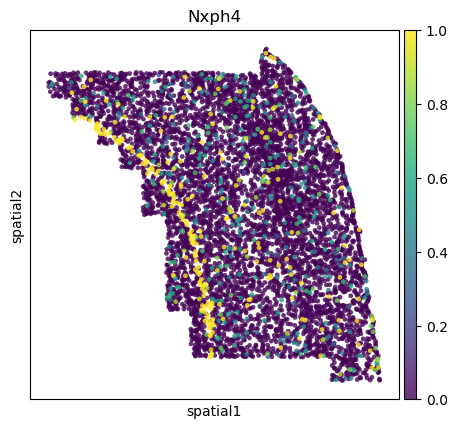

In [12]:
## look at nxph4 expression
## I think tangram converts to lowercase

sc.pl.spatial(
            adata_subset, 
            color="Nxph4", 
            title="Nxph4", 
            spot_size=40, 
            alpha=0.8, 
            cmap="viridis",
            vmax=1
        )

In [13]:
spatial_coords = adata_subset.obsm["spatial"]
norm_nxph4_expr = adata_subset[:, "Nxph4"].X.toarray().flatten()/max(adata_subset[:, "Nxph4"].X)  # Ensure it's 1D

In [14]:
# Extract Nxph4 expression values
nxph4_expr = adata_subset[:, "Nxph4"].X.toarray().flatten()  # Ensure it's a 1D array

# Create a boolean mask for cells with Nxph4 > cutoff
high_nxph4_mask = nxph4_expr > 7.5

# Subset the AnnData object
adata_subset_high_nxph4 = adata_subset[high_nxph4_mask].copy()

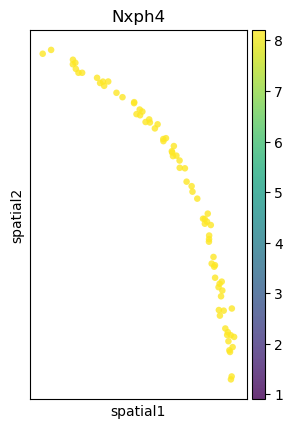

In [15]:
# plot subcortical line

sc.pl.spatial(
            adata_subset_high_nxph4, 
            color="Nxph4", 
            title="Nxph4", 
            spot_size=40, 
            alpha=0.8, 
            cmap="viridis",
            vmax=1
        )

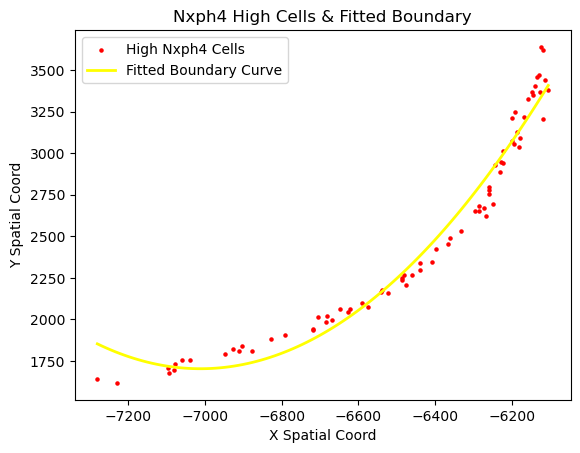

In [16]:
# Extract spatial coordinates
spatial_coords_high = adata_subset_high_nxph4.obsm["spatial"]

x_high = spatial_coords_high[:, 0]  # X-coordinates
y_high = spatial_coords_high[:, 1]  # Y-coordinates

# Fit a quadratic polynomial (or adjust degree as needed)
coeffs = np.polyfit(x_high, y_high, deg=2)  # Fit y = ax² + bx + c
poly_curve = np.poly1d(coeffs)

# Generate fitted y-values for a smooth curve
x_fit = np.linspace(x_high.min(), x_high.max(), 100)
y_fit = poly_curve(x_fit)

# Plot the fitted curve
plt.scatter(x_high, y_high, color="red", s=5, label="High Nxph4 Cells")
plt.plot(x_fit, y_fit, color="yellow", linewidth=2, label="Fitted Boundary Curve")
plt.xlabel("X Spatial Coord")
plt.ylabel("Y Spatial Coord")
plt.title("Nxph4 High Cells & Fitted Boundary")
plt.legend()
plt.show()

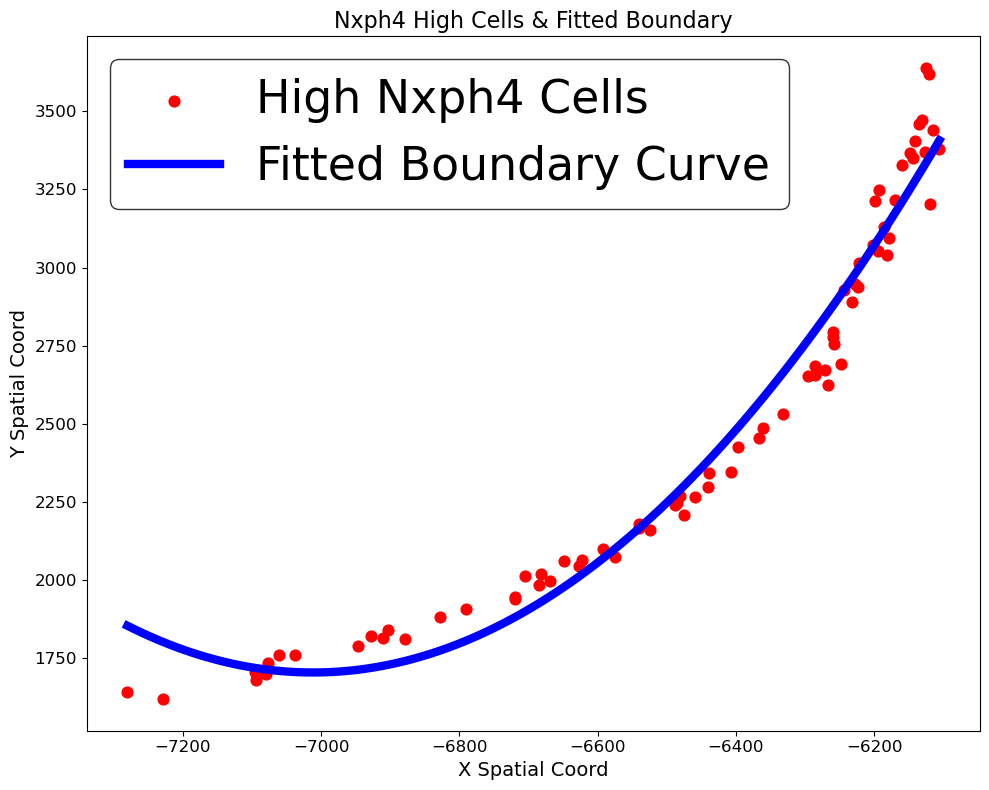

In [17]:
# Extract spatial coordinates
spatial_coords_high = adata_subset_high_nxph4.obsm["spatial"]
x_high = spatial_coords_high[:, 0]  # X-coordinates
y_high = spatial_coords_high[:, 1]  # Y-coordinates

# Fit a quadratic polynomial
coeffs = np.polyfit(x_high, y_high, deg=2)  # Fit y = ax² + bx + c
poly_curve = np.poly1d(coeffs)

# Generate fitted y-values for a smooth curve
x_fit = np.linspace(x_high.min(), x_high.max(), 100)
y_fit = poly_curve(x_fit)

# Create the plot with better visibility for posters
plt.figure(figsize=(10, 8))  # Larger figure size

# Plot the data points and curve
plt.scatter(x_high, y_high, color="red", s=60, label="High Nxph4 Cells")
plt.plot(x_fit, y_fit, color="blue", linewidth=6, label="Fitted Boundary Curve")  # Magenta with thicker line

# Improve axes and labels
plt.xlabel("X Spatial Coord", fontsize=14)
plt.ylabel("Y Spatial Coord", fontsize=14)
plt.title("Nxph4 High Cells & Fitted Boundary", fontsize=16)

# Make the legend larger and more visible
plt.legend(fontsize=33, frameon=True, facecolor='white', edgecolor='black')

# Optional: Add a grid for better readability
#plt.grid(True, linestyle='--', alpha=0.7)

# Optional: Set background color for contrast
#plt.gca().set_facecolor('#f0f0f0')  # Light gray background

# Improve tick labels size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [18]:
# Extract full spatial coordinates
spatial_coords = adata_subset.obsm["spatial"]

# Compute boundary y-values for all x positions
boundary_y = poly_curve(spatial_coords[:, 0])

# Identify subcortical cells (cells below the fitted boundary)
subcortical_mask = spatial_coords[:, 1] > boundary_y

# Remove subcortical cells from the full dataset
adata_filtered = adata_subset[~subcortical_mask].copy()

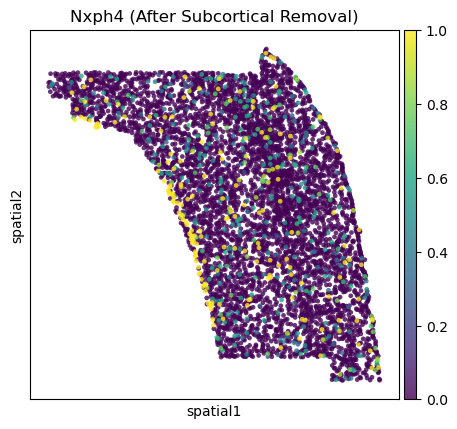

In [19]:
# Plot after removing subcortical cells
sc.pl.spatial(
    adata_filtered,
    color="Nxph4",
    title="Nxph4 (After Subcortical Removal)",
    spot_size=40,
    alpha=0.8,
    cmap="viridis",
    vmax=1
)

In [20]:
# Extract Nxph4 expression values
hi_nx = adata_filtered[:, "Nxph4"].X.toarray().flatten()

# Create a boolean mask for cells with Nxph4 > cutoff
hi_nxph4_mask = hi_nx > 7.5

# Subset the AnnData object
filt_high_nxph4 = adata_filtered[hi_nxph4_mask].copy()

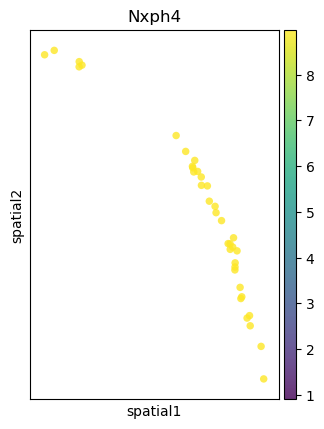

In [21]:
# some cells from the line remain

sc.pl.spatial(
            filt_high_nxph4, 
            color="Nxph4", 
            title="Nxph4", 
            spot_size=40, 
            alpha=0.8, 
            cmap="viridis",
            vmax=1
        )

In [22]:
adata_filtered=adata_filtered[~hi_nxph4_mask]

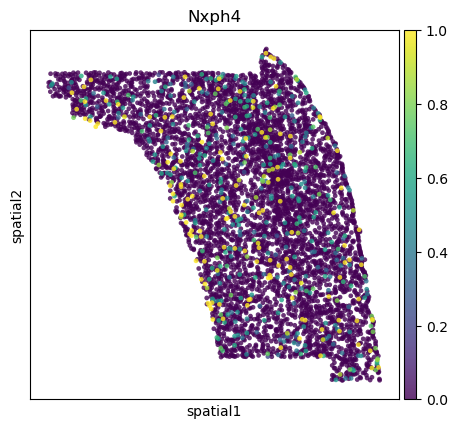

In [23]:
## finally

sc.pl.spatial(
            adata_filtered, 
            color="Nxph4", 
            title="Nxph4", 
            spot_size=40, 
            alpha=0.8, 
            cmap="viridis",
            vmax=1
        )

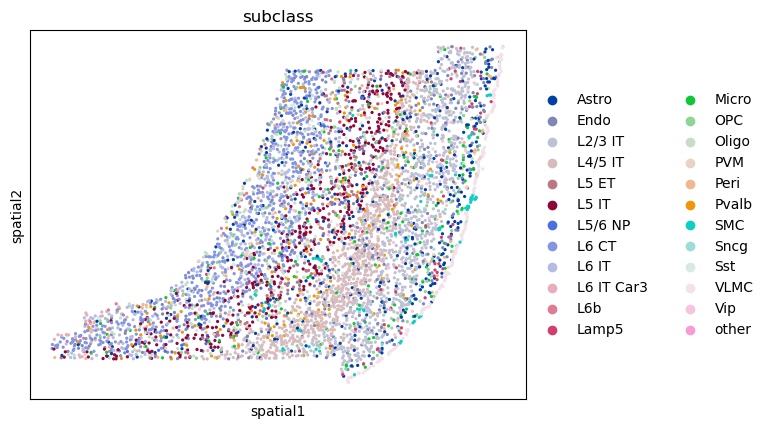

In [24]:
sc.pl.embedding(adata_filtered, basis="spatial", color="subclass")

In [25]:
# List of genes in Figure 2c
merfish_test_genes = ["Muc20", "Nr4a2", "Tcap", "Rxfp2", "Rxfp1", "Rspo1", "Sulf1", "Npas1", "Syt6"]

# Check which genes are available
available_genes = [gene for gene in merfish_test_genes if gene in adata_subset.var_names]
missing_genes = set(merfish_test_genes) - set(available_genes)

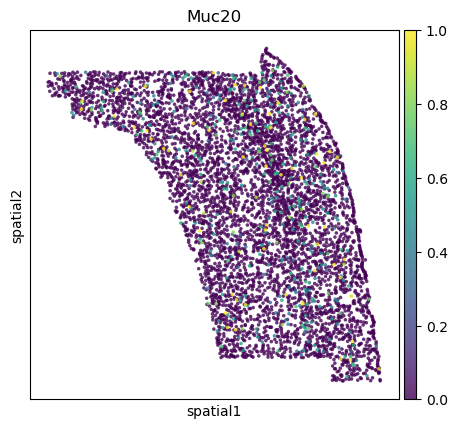

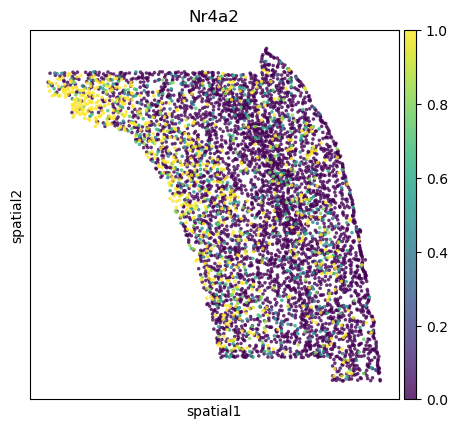

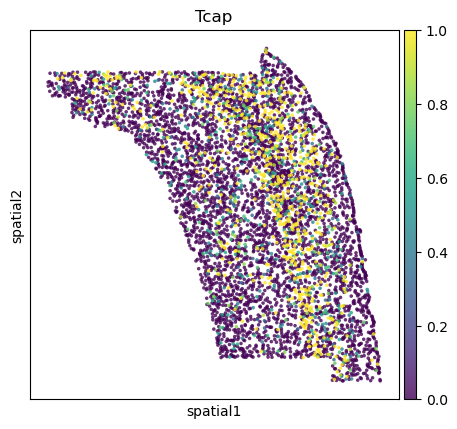

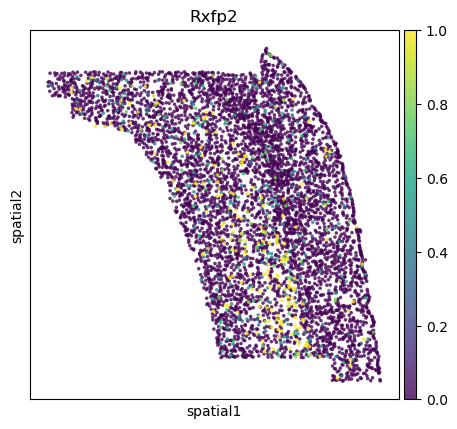

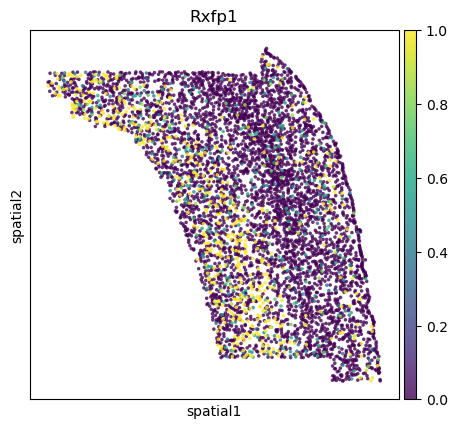

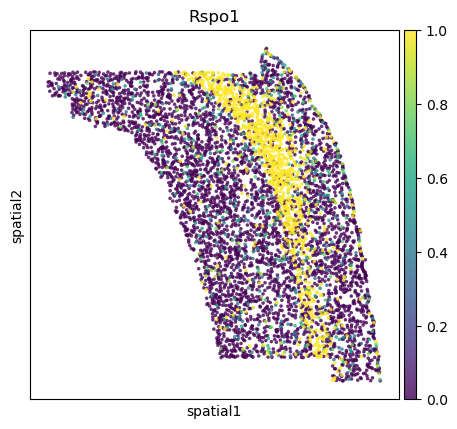

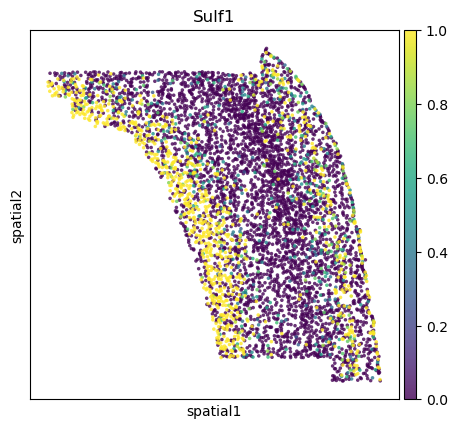

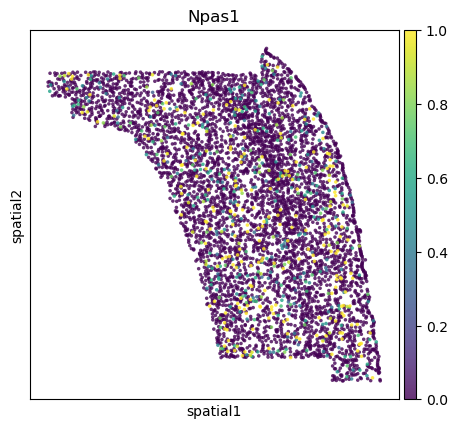

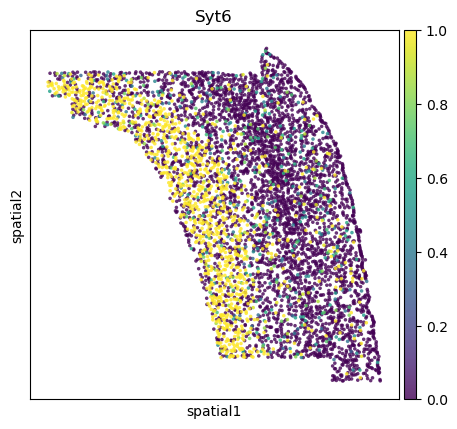

In [26]:
if "centroid_x" in adata_subset.obs.columns and "centroid_y" in adata_filtered.obs.columns:
    for gene in available_genes:
        sc.pl.spatial(
            adata_filtered, 
            color=gene, 
            title=gene, 
            spot_size=30, 
            alpha=0.8, 
            cmap="viridis",
            vmax=1
        )

In [36]:
# Drop the NaN column in obsm
#adata_filtered.obsm["tangram_ct_pred"] = adata_filtered.obsm["tangram_ct_pred"].loc[:, ~adata_filtered.obsm["tangram_ct_pred"].columns.isna()]

In [39]:
adata_filtered.write(filename="h5ad_files/spatial_filtered.h5ad")

## scRNA

In [2]:
adata_sc = ad.read_text("data/mouse_brain_data/GSM4156610_brain.rna.counts.txt.gz").T

In [3]:
cell_meta = pd.read_csv("data/mouse_brain_data/GSM4156599_brain_celltype.txt.gz", sep="\t")

In [4]:
adata_sc.obs["rna.bc"] = adata_sc.obs.index.astype(str)

In [5]:
cell_meta["rna.bc"] = cell_meta["rna.bc"].astype(str)

In [6]:
# Ensure the barcode in adata_sc.obs is a string and normalize the barcode format by replacing commas with periods
adata_sc.obs["rna.bc"] = adata_sc.obs["rna.bc"].astype(str).str.replace(",", ".")

# Ensure the barcode in cell_meta is a string (just in case)
cell_meta["rna.bc"] = cell_meta["rna.bc"].astype(str)

# Merge adata_sc.obs with cell_meta based on the barcode
adata_sc.obs = adata_sc.obs.merge(cell_meta[["rna.bc", "celltype"]], on="rna.bc", how="left")

In [7]:
sc.pp.calculate_qc_metrics(adata_sc, inplace=True, log1p=True)

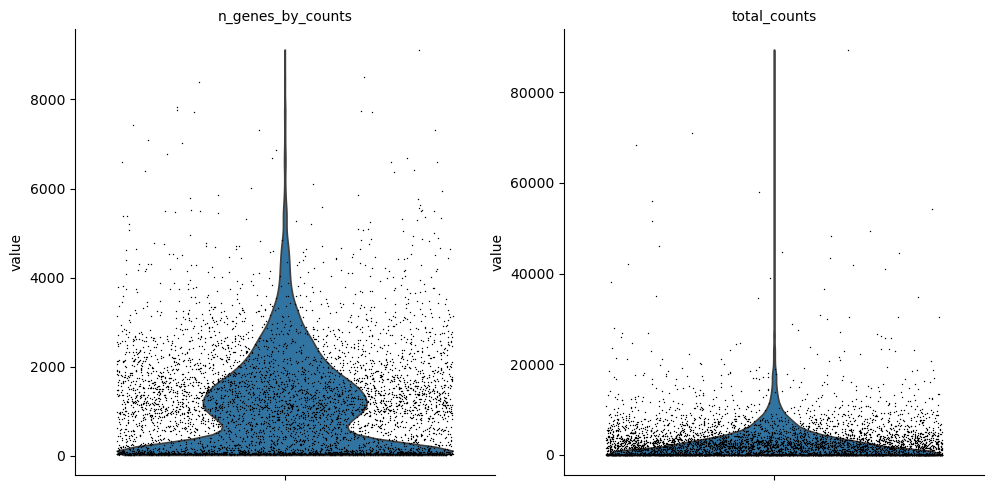

In [8]:
sc.pl.violin(
    adata_sc,
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,

)

In [52]:
#sc.pp.filter_cells(adata_sc, min_genes=100)
#sc.pp.filter_genes(adata_sc, min_cells=3)

#sc.pp(adata_sc) scrublet?

In [53]:
# Saving count data
adata_sc.layers["counts"] = adata_sc.X.copy()

In [54]:
sc.pp.normalize_total(adata_sc, target_sum=1e4)  # Normalize to 10,000 reads per cell
sc.pp.log1p(adata_sc)  # Log-transform counts

In [55]:
#sc.pp.highly_variable_genes(adata_sc, n_top_genes=2000)
#sc.pp.highly_variable_genes(adata_sc, min_mean=0.0125, max_mean=3, min_disp=0.5)
#adata_sc = adata_sc[:, adata_sc.var["highly_variable"]]

In [56]:
#sc.pl.highly_variable_genes(adata_sc)

In [57]:
sc.tl.pca(adata_sc, n_comps=50)
#sc.pp.neighbors(adata_sc, n_neighbors=10, n_pcs=40)

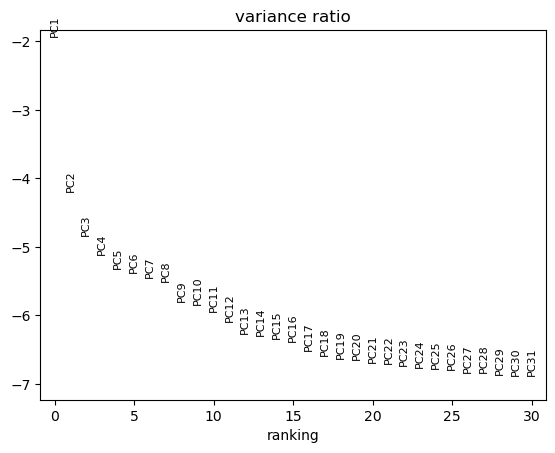

In [58]:
sc.pl.pca_variance_ratio(adata_sc, log=True)
#keep 50

In [59]:
sc.pp.neighbors(adata_sc, n_pcs=50)

In [60]:
sc.tl.umap(adata_sc)

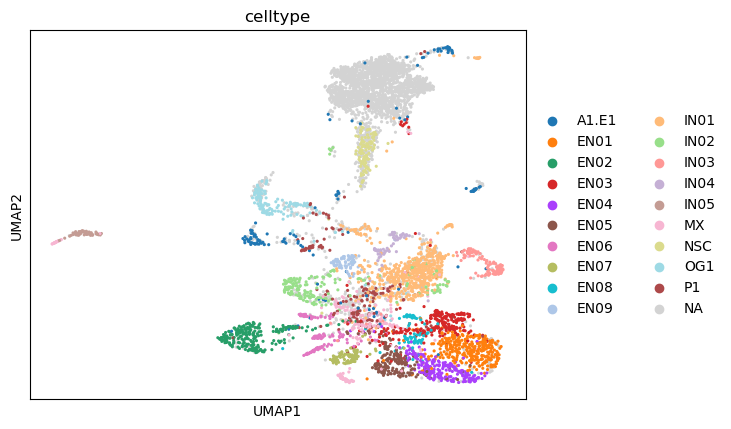

In [61]:
sc.pl.umap(
    adata_sc,
    color="celltype",
)

In [62]:
sc.tl.rank_genes_groups(adata=adata_sc, groupby="celltype", method="t-test")

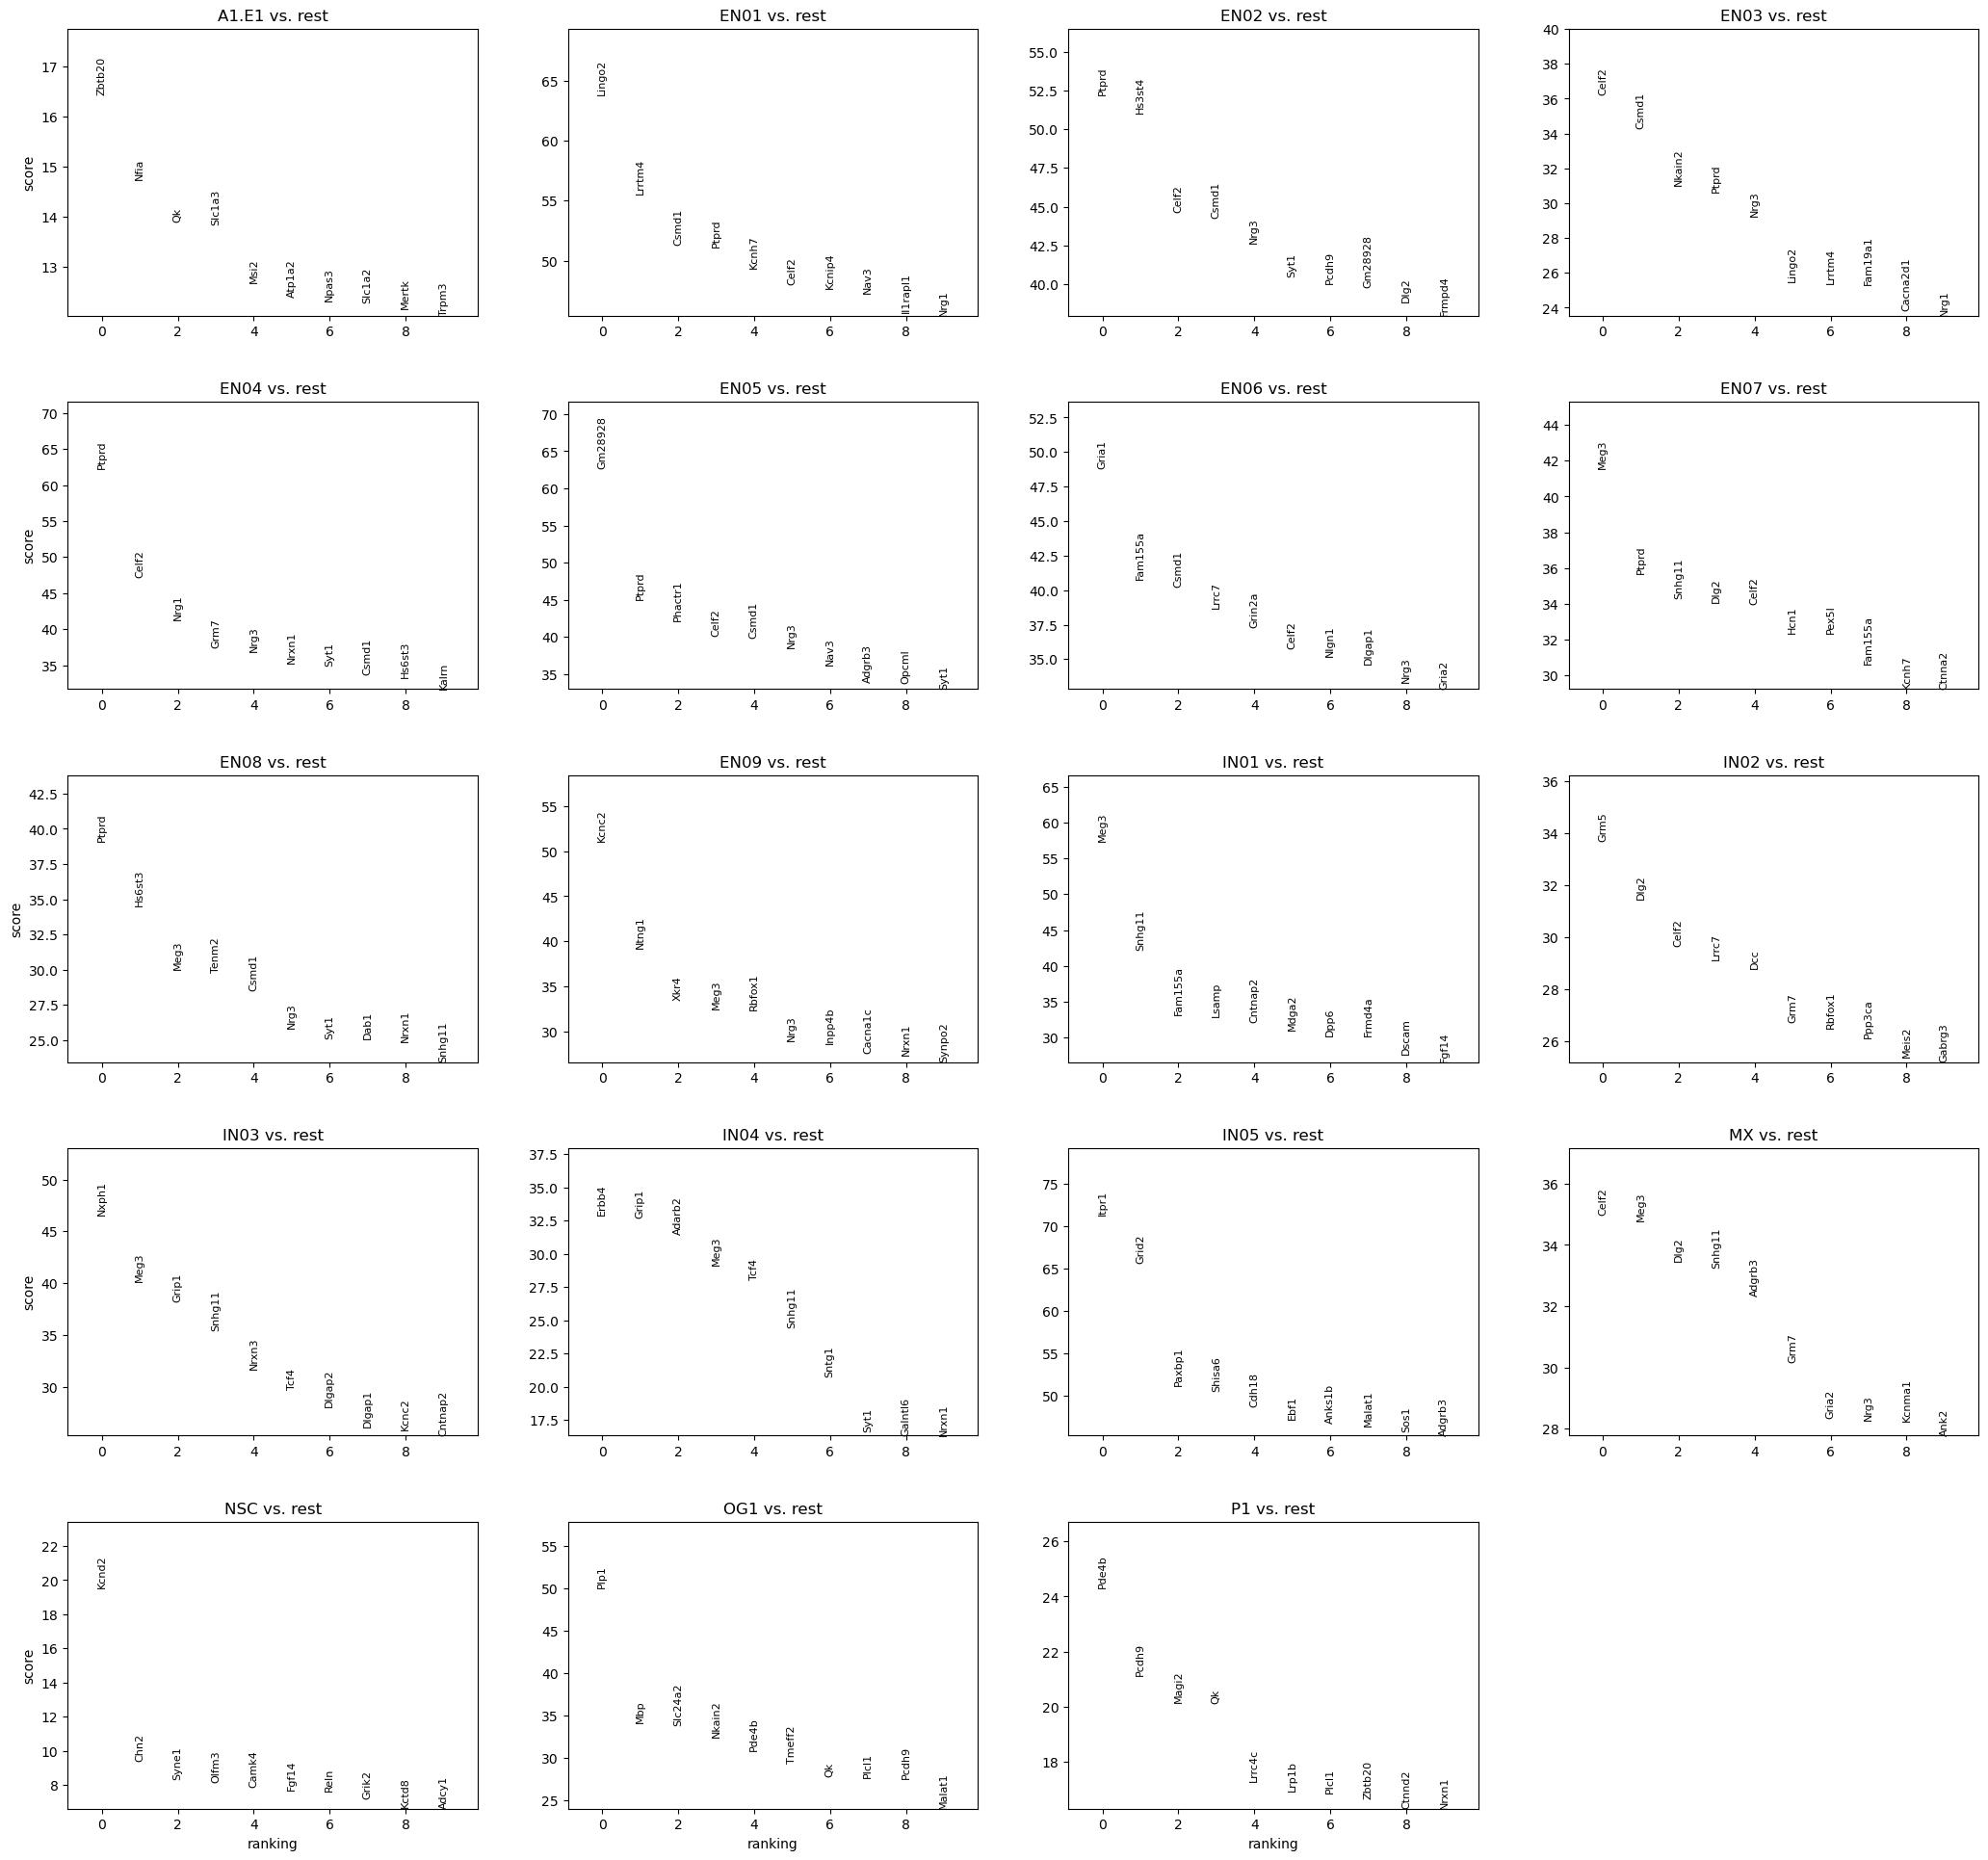

In [63]:
sc.pl.rank_genes_groups(adata_sc, n_genes=10, sharey=False)

In [65]:
marker_genes = sc.get.rank_genes_groups_df(adata_sc, group=None)  # Get all ranked genes

In [66]:
top_marker_genes = marker_genes.groupby("group").head(100)

In [68]:
unique_marker_genes = top_marker_genes["names"].unique()

marker_gene_list = list(unique_marker_genes)

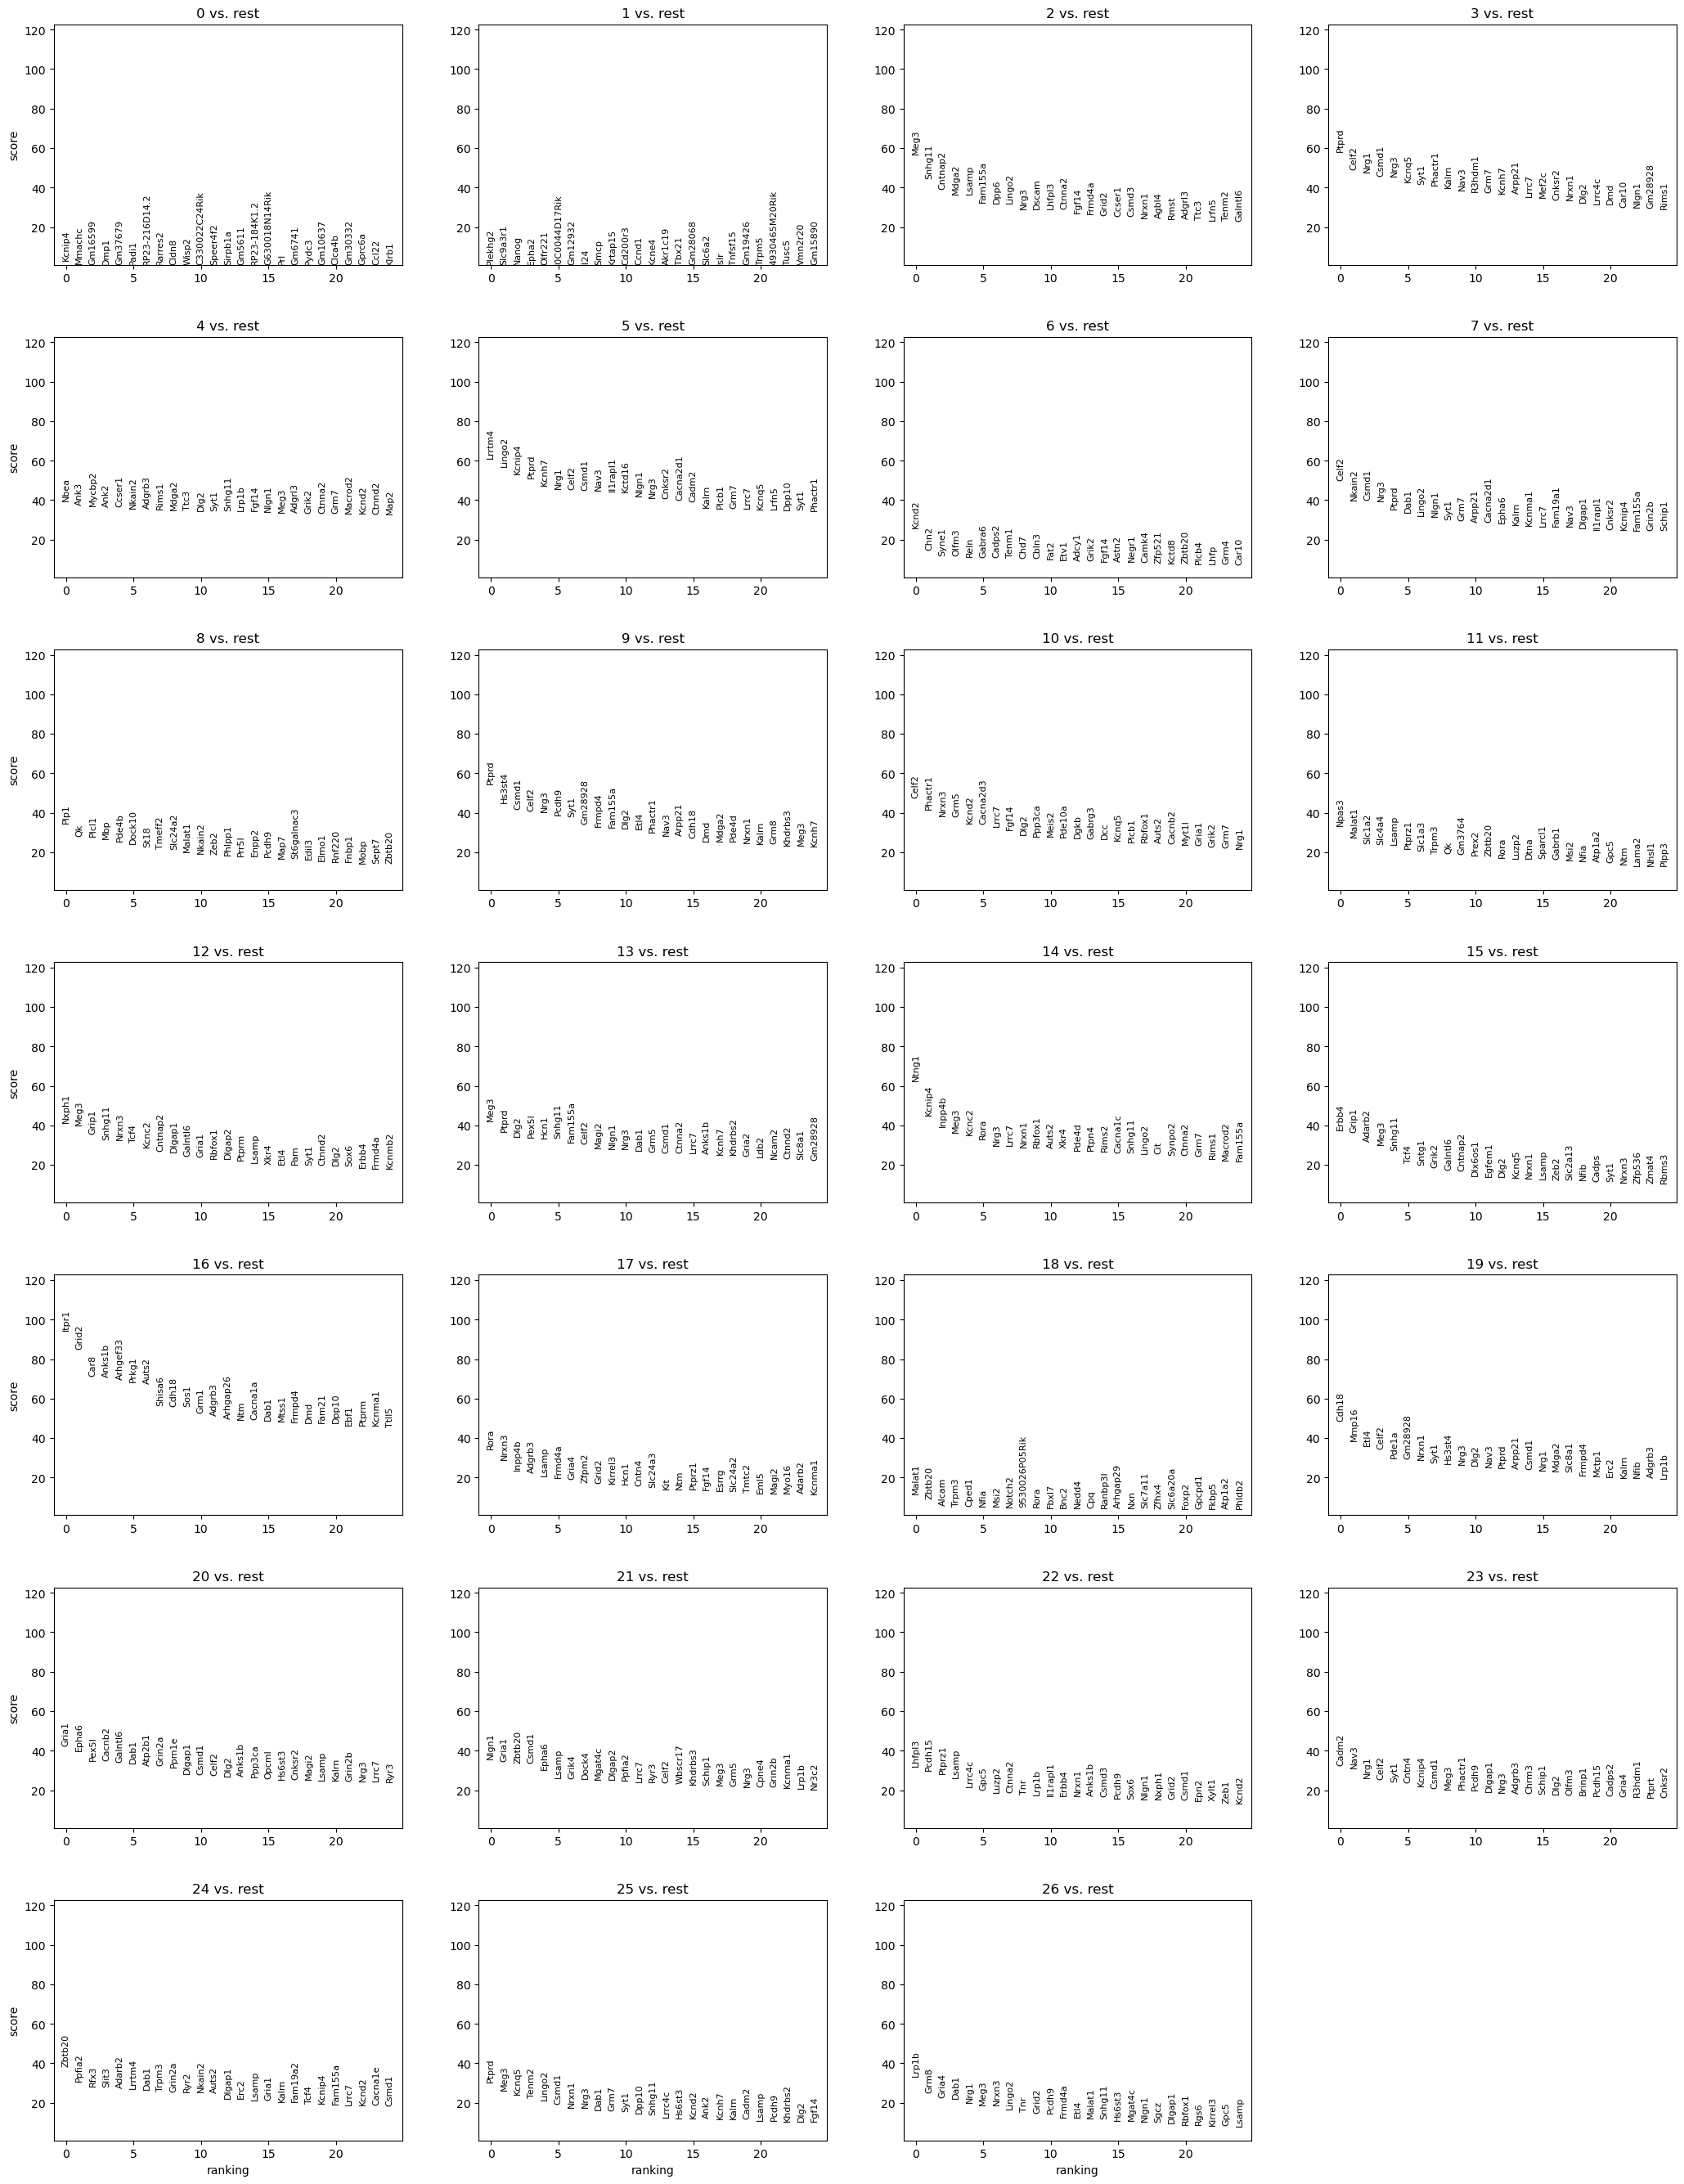

In [53]:
#skip

sc.tl.leiden(
    adata_sc,
    resolution=0.9,
    random_state=0,

    n_iterations=2,
    directed=False,
)

sc.tl.rank_genes_groups(adata_sc, "leiden", method="t-test")

sc.pl.rank_genes_groups(adata_sc, n_genes=25)

In [54]:
sc.tl.leiden(adata_sc, n_iterations=2)

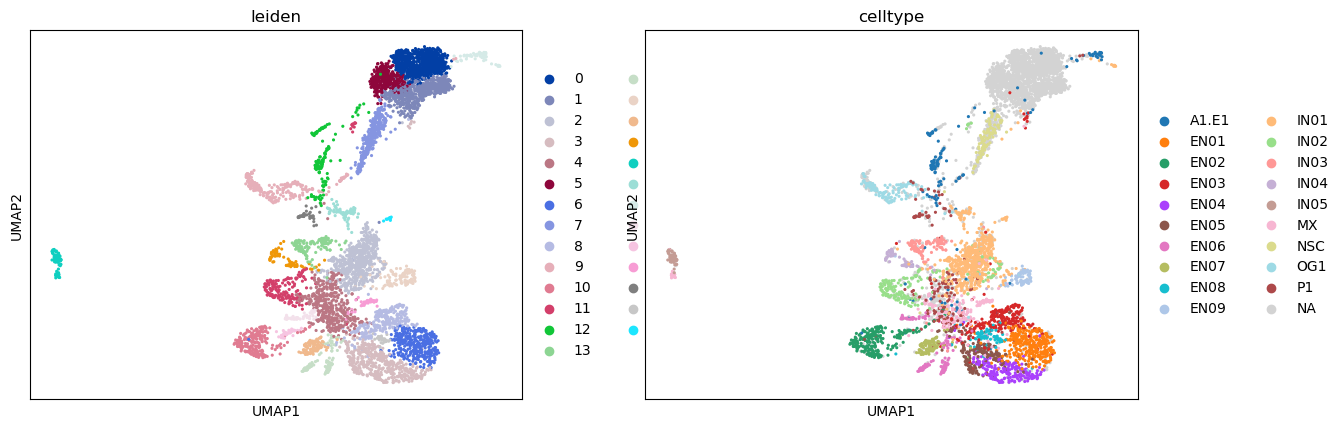

In [55]:
sc.pl.umap(adata_sc, color=["leiden", "celltype"])

In [93]:
#adata_sc.write("h5ad_files/sc.h5ad")

## ATAC

In [1]:
# Load peak-by-cell matrix
#atac_counts = pd.read_csv("data/mouse_brain_data/GSM4156599_brain.counts.txt.gz", sep="\t", index_col=0)
#atac_counts = pd.read_csv("data/mouse_brain_data/GSM4156599_brain.counts.txt.gz", sep="\t")

GSM4156599_brain.atac.fragments.bed.gz	GSM4156599_brain.barcodes.txt.gz  GSM4156599_brain.counts.txt.gz  GSM4156599_brain.peaks.bed.gz  GSM4156599_brain_celltype.txt.gz  GSM4156610_brain.rna.counts.txt.gz

In [10]:
atac = sc.read_mtx("data/mouse_brain_data/GSM4156599_brain.counts.txt.gz").T

barcodes = pd.read_csv("data/mouse_brain_data/GSM4156599_brain.barcodes.txt.gz", header=None)

atac.obs["barcode"] = barcodes[0].values

peaks = pd.read_csv("data/mouse_brain_data/GSM4156599_brain.peaks.bed.gz",
                    sep="\t", header=None, names=["chrom", "start", "end"])

# Create peak ids
peaks["peak_id"] = peaks["chrom"] + ":" + peaks["start"].astype(str) + "-" + peaks["end"].astype(str)

peaks.set_index("peak_id", inplace=True)
atac.var = peaks


rna_barcodes = cell_meta["rna.bc"].tolist()

adata_sc_subset = adata_sc[adata_sc.obs["rna.bc"].isin(rna_barcodes), :]

atac.obs = atac.obs.merge(cell_meta[["rna.bc", "celltype"]], left_on="barcode", right_on="rna.bc")

atac.obs = atac.obs.drop(["rna.bc"],axis=1)

atac.write("atac.h5ad")

In [71]:
adata_sc_subset.write("h5ad_files/subsetted_sc.h5ad")

Hier hatte ich den Verdacht, dass ich eine Zelle hier drüber ausversehen RNA Barcodes dem ATAC ad gegeben hab, das wollte ich hier korrigieren. Ich lese dann auch in ATAC_mapping.ipynb atac_with_correct_barcodes.h5ad anstatt atac.h5ad ein.

In [13]:
# Load ATAC data
atac = sc.read_mtx("data/mouse_brain_data/GSM4156599_brain.counts.txt.gz").T
barcodes = pd.read_csv("data/mouse_brain_data/GSM4156599_brain.barcodes.txt.gz", header=None)
atac.obs["barcode"] = barcodes[0].values

# Load peaks
peaks = pd.read_csv("data/mouse_brain_data/GSM4156599_brain.peaks.bed.gz",
                   sep="\t", header=None, names=["chrom", "start", "end"])
peaks["peak_id"] = peaks["chrom"] + ":" + peaks["start"].astype(str) + "-" + peaks["end"].astype(str)
peaks.set_index("peak_id", inplace=True)
atac.var = peaks

# Check barcode formats
print("ATAC barcodes (first 5):", atac.obs["barcode"].values[:5])
print("Cell meta ATAC barcodes (first 5):", cell_meta["atac.bc"].values[:5])
print("Cell meta RNA barcodes (first 5):", cell_meta["rna.bc"].values[:5])

# The issue is that barcodes in atac.obs["barcode"] are actually RNA barcodes
# Let's check this:
overlap_with_rna = set(atac.obs["barcode"]) & set(cell_meta["rna.bc"])
overlap_with_atac = set(atac.obs["barcode"]) & set(cell_meta["atac.bc"])
print(f"Overlap with RNA barcodes: {len(overlap_with_rna)}")
print(f"Overlap with ATAC barcodes: {len(overlap_with_atac)}")

# Since barcodes.txt.gz contains RNA barcodes, we need to map them to ATAC barcodes
# Create a mapping dictionary from RNA to ATAC
rna_to_atac = dict(zip(cell_meta["rna.bc"], cell_meta["atac.bc"]))

# Add ATAC barcode column based on RNA barcodes
atac.obs["atac_barcode"] = [rna_to_atac.get(bc, "unknown") for bc in atac.obs["barcode"]]

# Format ATAC barcodes for fragments file
import re
formatted_barcodes = []
for bc in atac.obs["atac_barcode"]:
    components = re.findall(r'(R\d+\.\d+|P\d+\.\d+)', bc)
    formatted_bc = ','.join(components)
    formatted_barcodes.append(formatted_bc)

# Add formatted barcodes
atac.obs["formatted_barcode"] = formatted_barcodes

# Set formatted barcodes as observation names
atac.obs_names = atac.obs["formatted_barcode"].values

# Add cell type information directly
atac.obs["celltype"] = atac.obs["barcode"].map(dict(zip(cell_meta["rna.bc"], cell_meta["celltype"])))

# Save the corrected ATAC data
atac.write("h5ad_files/atac_with_correct_barcodes.h5ad")

ATAC barcodes (first 5): ['R1.01.R2.04.R3.55.P1.40' 'R1.01.R2.05.R3.35.P1.40'
 'R1.01.R2.08.R3.45.P1.39' 'R1.01.R2.08.R3.78.P1.39'
 'R1.01.R2.09.R3.52.P1.40']
Cell meta ATAC barcodes (first 5): ['R1.01.R2.04.R3.55.P1.32' 'R1.01.R2.05.R3.35.P1.32'
 'R1.01.R2.08.R3.45.P1.31' 'R1.01.R2.08.R3.78.P1.31'
 'R1.01.R2.09.R3.52.P1.32']
Cell meta RNA barcodes (first 5): ['R1.01.R2.04.R3.55.P1.40' 'R1.01.R2.05.R3.35.P1.40'
 'R1.01.R2.08.R3.45.P1.39' 'R1.01.R2.08.R3.78.P1.39'
 'R1.01.R2.09.R3.52.P1.40']
Overlap with RNA barcodes: 3293
Overlap with ATAC barcodes: 0


## Tangram with filtered MERFISH

In [102]:
# Convert gene names to sets (case-insensitive comparison)
overlapping_genes = set(adata_sc.var_names.str.lower()) & set(adata_filtered.var_names.str.lower())

In [58]:
tg.pp_adatas(adata_sc, adata_filtered, genes=overlapping_genes)

INFO:root:245 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:245 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [59]:
'''
ad_map_filtered = tg.map_cells_to_space(adata_sc, adata_filtered,
    mode="cells",
#     mode="clusters",
#     cluster_label='cell_subclass',  # .obs field w cell types
    density_prior='rna_count_based',
    num_epochs=500,
    # device="cuda:0",
    device='cpu',
)
'''

'\nad_map_filtered = tg.map_cells_to_space(adata_sc, adata_filtered,\n    mode="cells",\n#     mode="clusters",\n#     cluster_label=\'cell_subclass\',  # .obs field w cell types\n    density_prior=\'rna_count_based\',\n    num_epochs=500,\n    # device="cuda:0",\n    device=\'cpu\',\n)\n'

In [112]:
tg.project_cell_annotations(ad_map_filtered, adata_filtered, annotation="celltype")
copy_annotation_list = list(pd.unique(adata_sc.obs['celltype']))

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


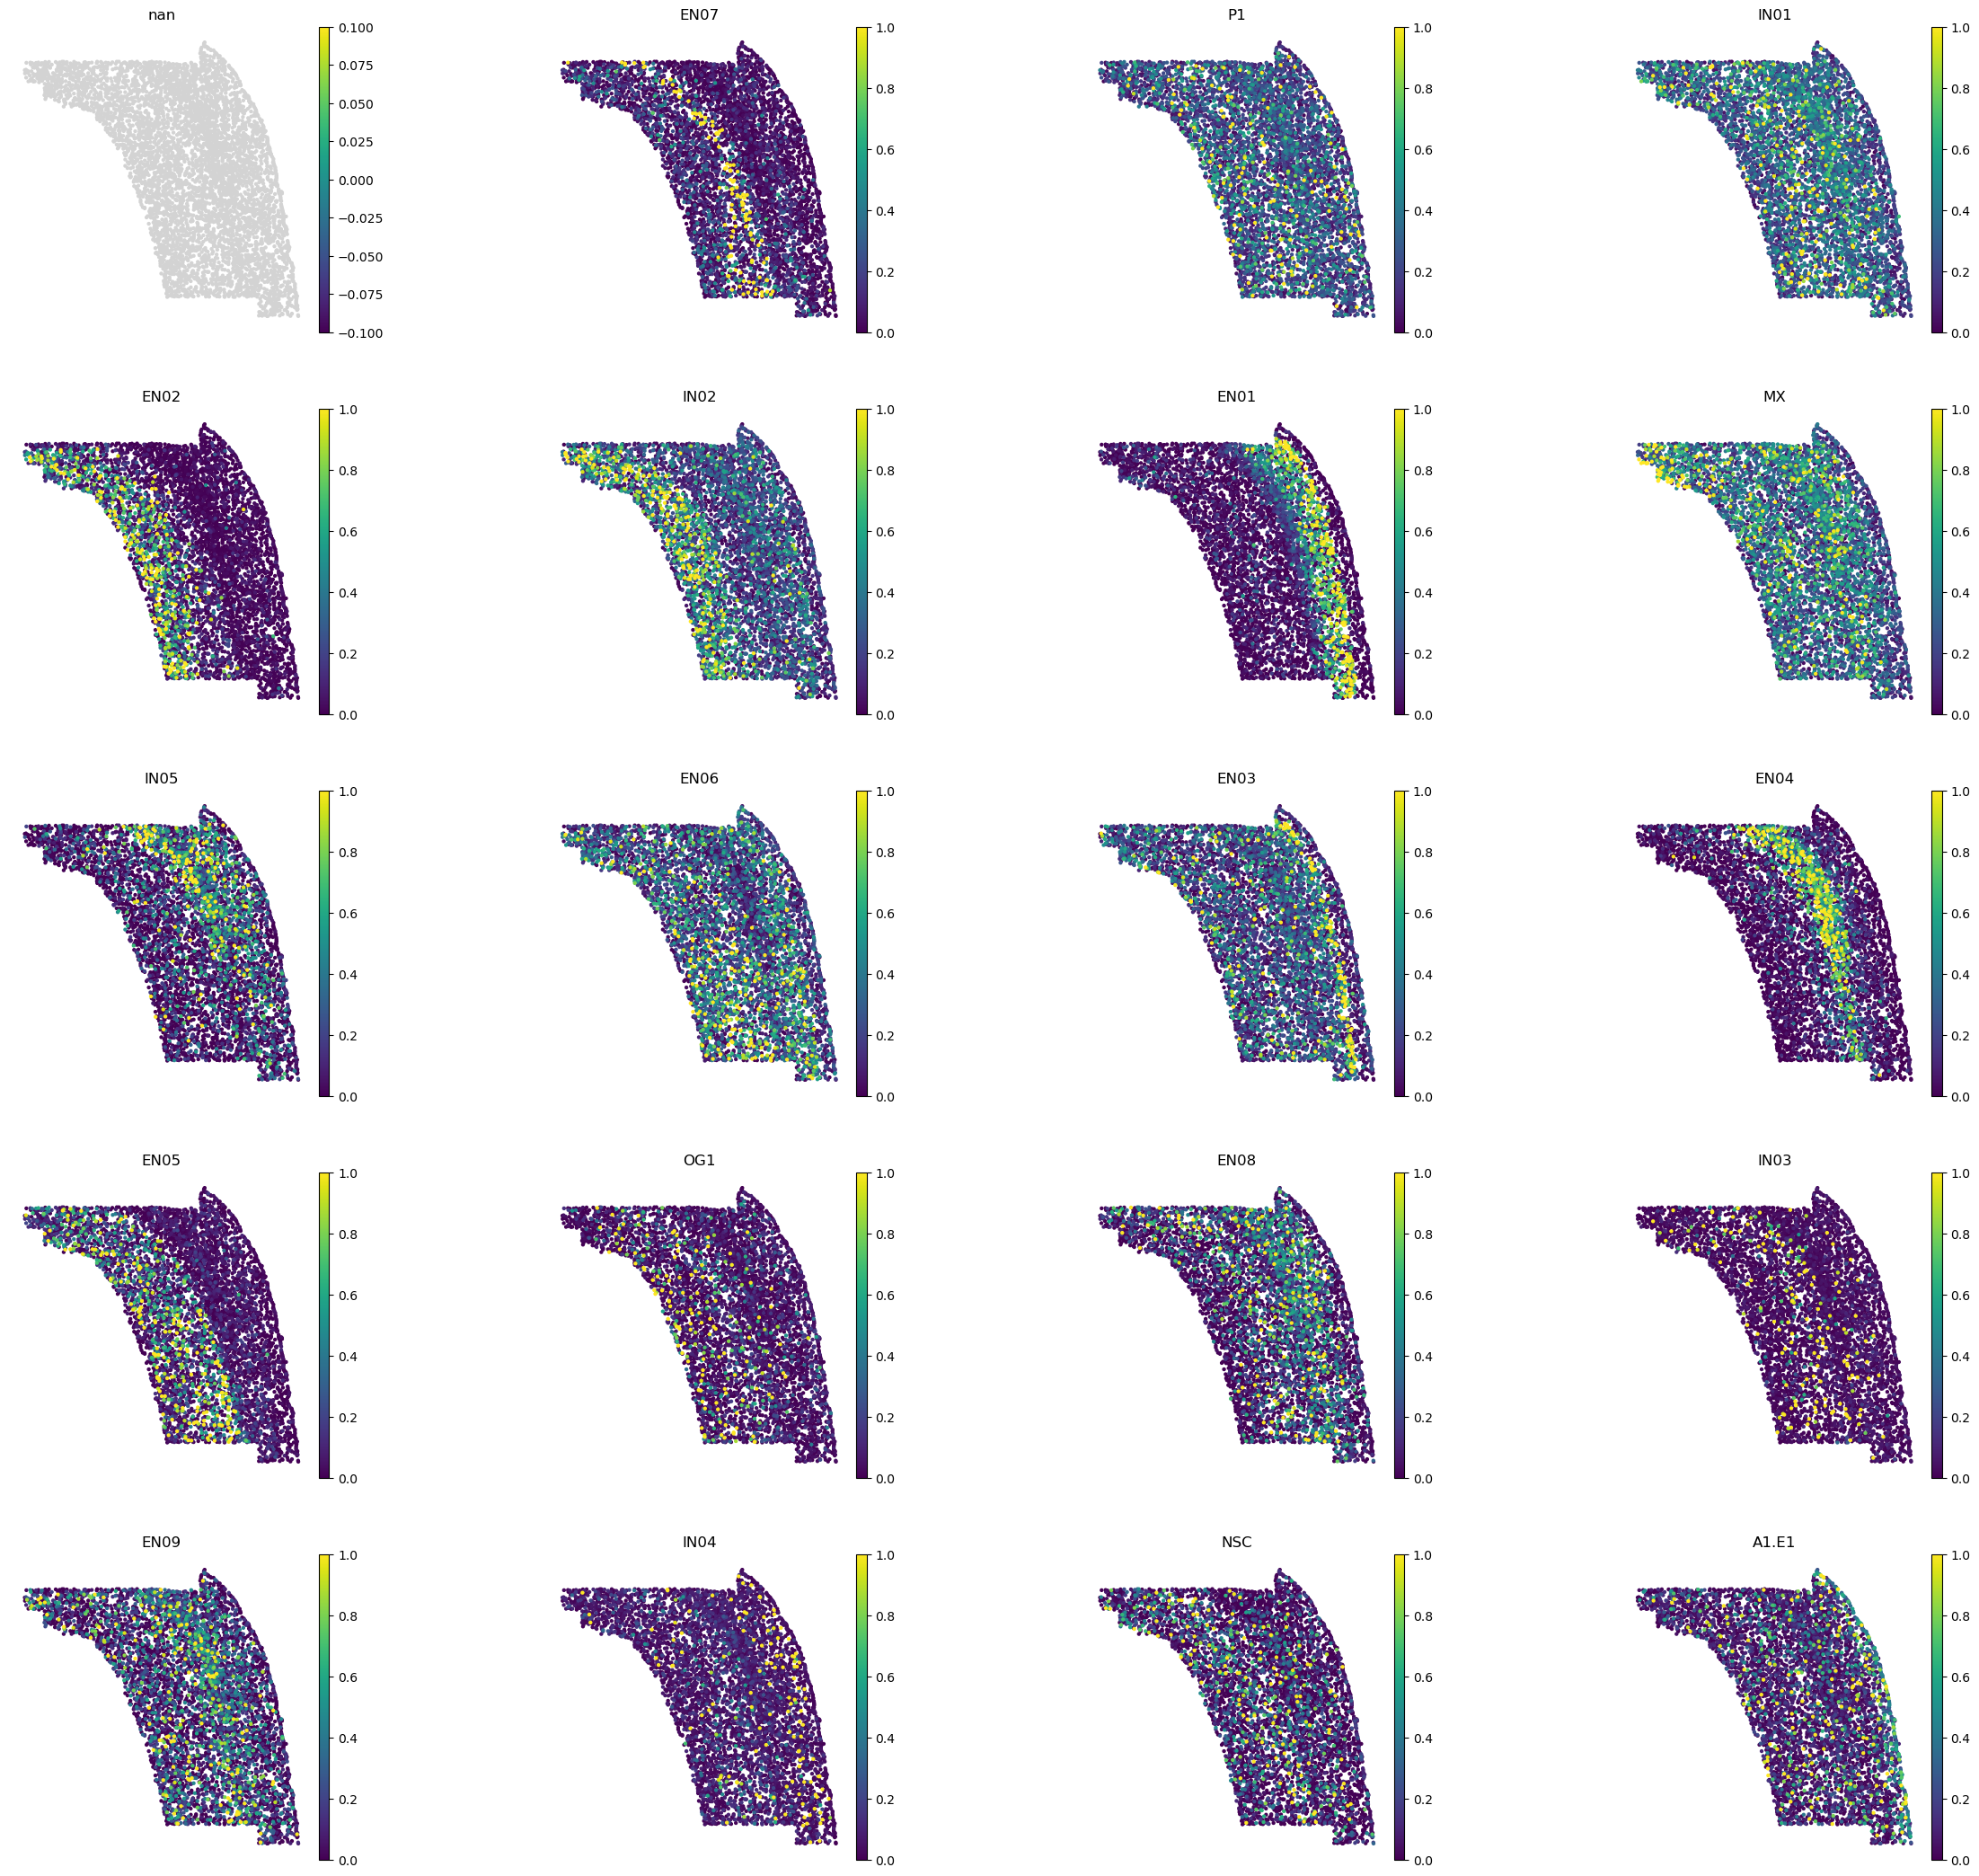

In [62]:
tg.plot_cell_annotation_sc(adata_filtered, copy_annotation_list, spot_size=40, perc=0.02)

In [63]:
gene_ad_filtered= tg.project_genes(ad_map_filtered, adata_sc)

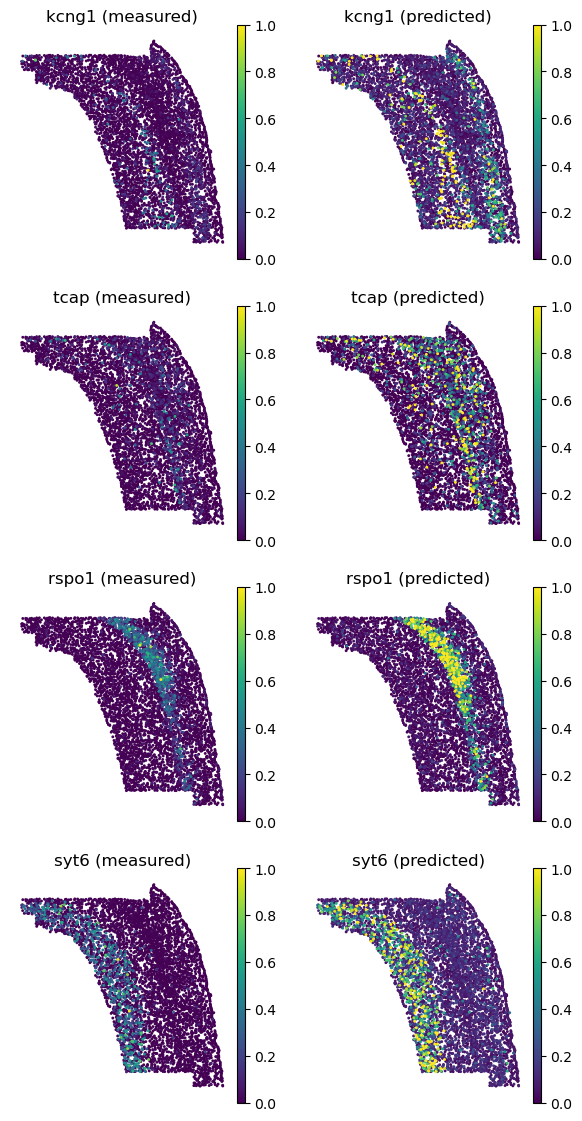

In [61]:
tg.plot_genes_sc(genes=["kcng1", "tcap", "rspo1", "syt6"], adata_measured=adata_filtered, adata_predicted=gene_ad_filtered, spot_size=40, perc=0.02,cmap="viridis")

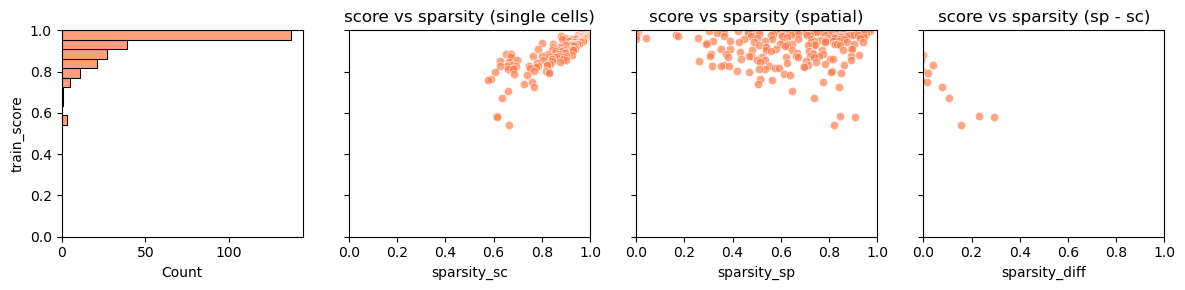

In [64]:
tg.plot_utils.plot_training_scores(ad_map_filtered)

In [107]:
tg.pp_adatas(adata_sc_subset, adata_filtered, genes=overlapping_genes)

INFO:root:243 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:243 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [108]:
'''
ad_map_newest = tg.map_cells_to_space(adata_sc_subset, adata_filtered,
    mode="cells",
#     mode="clusters",
#     cluster_label='cell_subclass',  # .obs field w cell types
    density_prior='rna_count_based',
    num_epochs=500,
    # device="cuda:0",
    device='cpu',
)
'''

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 243 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.343, KL reg: 0.073
Score: 0.891, KL reg: 0.002
Score: 0.898, KL reg: 0.002
Score: 0.900, KL reg: 0.002
Score: 0.901, KL reg: 0.002


INFO:root:Saving results..
